In [ ]:
import pandas as pd

In [ ]:
#connect to personal google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data exploration 

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/UTRECHT UNIVERISTY/THESIS/DATA/HAIQI_DATA/df_iob_tags_final44.csv", encoding="latin1")
data.head(10)

,ID,question,token,pos,tag
0,0,What is percentage of households within 2000 m...,What,PRON,O
1,0,What is percentage of households within 2000 m...,is,AUX,O
2,0,What is percentage of households within 2000 m...,percentage,NOUN,B-PROPIR
3,0,What is percentage of households within 2000 m...,of,ADP,O
4,0,What is percentage of households within 2000 m...,households,NOUN,B-OBJ
5,0,What is percentage of households within 2000 m...,within,ADP,O
6,0,What is percentage of households within 2000 m...,2000,NUM,O
7,0,What is percentage of households within 2000 m...,metres,NOUN,O
8,0,What is percentage of households within 2000 m...,from,ADP,O
9,0,What is percentage of households within 2000 m...,supermarkets,NOUN,B-OBJ


In [ ]:
data.shape

(4096, 5)

In [ ]:
data.rename(columns={'token': 'word', 'IOB Tags': 'tag'}, inplace=True)

In [ ]:
data

,ID,question,word,pos,tag
0,0,What is percentage of households within 2000 m...,What,PRON,O
1,0,What is percentage of households within 2000 m...,is,AUX,O
2,0,What is percentage of households within 2000 m...,percentage,NOUN,B-PROPIR
3,0,What is percentage of households within 2000 m...,of,ADP,O
4,0,What is percentage of households within 2000 m...,households,NOUN,B-OBJ
...,...,...,...,...,...
4091,317,What is density of greens for each PC4 area in...,PC4,PROPN,B-OBJ
4092,317,What is density of greens for each PC4 area in...,area,NOUN,I-OBJ
4093,317,What is density of greens for each PC4 area in...,in,ADP,O
4094,317,What is density of greens for each PC4 area in...,PlaceName0,PROPN,O


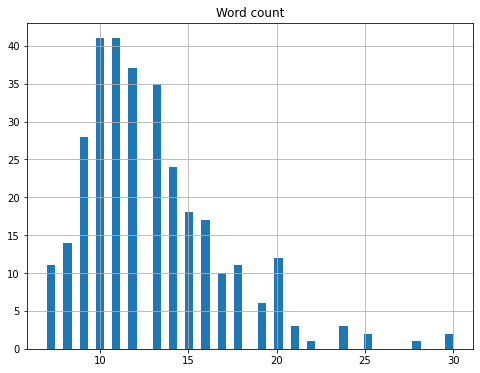

In [ ]:
word_counts = data.groupby("question")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

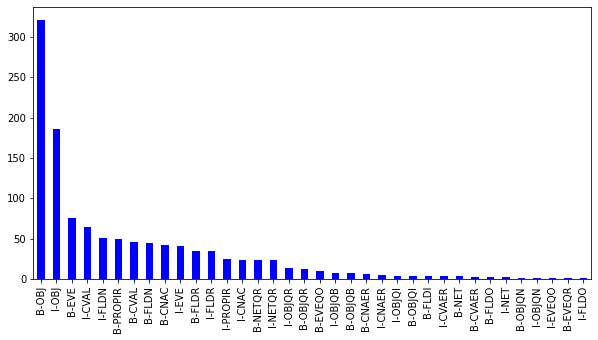

In [ ]:
data[data["tag"]!="O"]["tag"].value_counts().plot(kind="bar", color='blue', figsize=(10,5))

In [ ]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 30 words.


In [ ]:
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is: {}.".format(longest_sentence_id))

ID of the longest sentence is: What areas are within 10 minutes , 30 minutes , and 60 minutes of driving time from private hospitals in PlaceName0 in PlaceName1
.


 ### Extract mappings necessary for the neural network

In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['word'].to_list()))
    else:
        vocab = list(set(data['tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['word_idx'] = data['word'].map(token2idx)
data['tag_idx'] = data['tag'].map(tag2idx) 

In [ ]:
data.head()

,ID,question,word,pos,tag,word_idx,tag_idx
0,0,What is percentage of households within 2000 m...,What,PRON,O,326,3
1,0,What is percentage of households within 2000 m...,is,AUX,O,204,3
2,0,What is percentage of households within 2000 m...,percentage,NOUN,B-PROPIR,408,24
3,0,What is percentage of households within 2000 m...,of,ADP,O,442,3
4,0,What is percentage of households within 2000 m...,households,NOUN,B-OBJ,139,14


In [ ]:
data.isna().any()

ID          False
question    False
word        False
pos         False
tag         False
word_idx    False
tag_idx     False
dtype: bool

### Transform columns to extract sequential data

In [ ]:
#fill NaN in case they exist.
#data_fillna = data.fillna(method='ffill', axis=0)

#group data by question
data_group = data.groupby(['question'],as_index=False
                                )['word', 'pos', 'tag', 'word_idx', 'tag_idx'].agg(lambda x: list(x))
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,question,word,pos,tag,word_idx,tag_idx
0,From where are wind farms visible in PlaceName0\n,"[From, where, are, wind, farms, visible, in, P...","[ADP, ADV, AUX, NOUN, NOUN, ADJ, ADP, PROPN, S...","[O, O, O, B-OBJ, I-OBJ, O, O, O, O]","[305, 519, 488, 80, 182, 265, 429, 12, 407]","[3, 3, 3, 14, 13, 3, 3, 3, 3]"
1,How many arson cases in PlaceName0 in February...,"[How, many, arson, cases, in, in, PlaceName0, ...","[ADV, ADJ, NOUN, NOUN, ADP, ADP, PROPN, PROPN,...","[O, O, B-EVE, I-EVE, O, O, O, O, O, O]","[141, 428, 260, 450, 429, 429, 12, 403, 181, 407]","[3, 3, 19, 26, 3, 3, 3, 3, 3, 3]"
2,How many buildings are affected by hurricane i...,"[How, many, buildings, are, affected, by, hurr...","[ADV, ADJ, NOUN, AUX, VERB, ADP, NOUN, ADP, PR...","[O, O, B-OBJ, O, O, O, B-EVE, O, O, O]","[141, 428, 300, 488, 225, 5, 125, 429, 12, 407]","[3, 3, 14, 3, 3, 3, 19, 3, 3, 3]"
3,How many buildings are within 3 minutes of dri...,"[How, many, buildings, are, within, 3, minutes...","[ADV, ADJ, NOUN, AUX, ADP, NUM, NOUN, ADP, VER...","[O, O, B-OBJ, O, O, O, O, O, B-NETQR, I-NETQR,...","[141, 428, 300, 488, 65, 164, 372, 442, 83, 6,...","[3, 3, 14, 3, 3, 3, 3, 3, 11, 33, 3, 14, 13, 3..."
4,How many dwelling units are in flood zones in ...,"[How, many, dwelling, units, are, in, in, floo...","[ADV, ADJ, NOUN, NOUN, AUX, ADP, ADP, NOUN, NO...","[O, O, B-OBJ, I-OBJ, O, O, O, B-FLDN, I-FLDN, ...","[141, 428, 133, 496, 488, 429, 429, 547, 287, ...","[3, 3, 14, 13, 3, 3, 3, 20, 16, 3, 3]"


### Split the dataset into train and test set after padding

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
def get_pad_train_test_val(data_group, data):
    n_token = len(list(set(data['word'].to_list())))
    n_tag = len(list(set(data['tag'].to_list())))
    
    tokens = data_group['word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)


    tags = data_group['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2018)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntrain_tags:', len(train_tags),
        '\ntest_tags:', len(test_tags)
    )
    
    return train_tokens, test_tokens, train_tags, test_tags

train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 285 
test_tokens length: 32 
train_tags: 285 
test_tags: 32


In [ ]:
for token, tag in zip(train_tokens[0], train_tags[0]):
    print('%s\t%s' % (token, tag))

326	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
488	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
294	[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
546	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
169	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
442	[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
47	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
47	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
47	[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 

### Build the Bi-LSTM model's architecture

In [ ]:
import numpy as np
import tensorflow 
from tensorflow import keras
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = len(list(set(data['word'].to_list())))+1
output_dim = 256
input_length = max([len(s) for s in data_group['word_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  553 
output_dim:  256 
input_length:  30 
n_tags:  37


In [ ]:
n_tags = len(tag2idx)

In [ ]:
n_tags

37

#Bi-LSTM model's architecture


In [ ]:
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.4, recurrent_dropout=0.0), merge_mode = 'concat'))
    

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.4, recurrent_dropout=0.0))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 256)           141568    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 512)          1050624   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           787456    
                                                                 
 time_distributed (TimeDistr  (None, 30, 37)           9509      
 ibuted)                                                         
                                                                 
Total params: 1,989,157
Trainable params: 1,989,157
Non-trainable params: 0
_________________________________________________________________


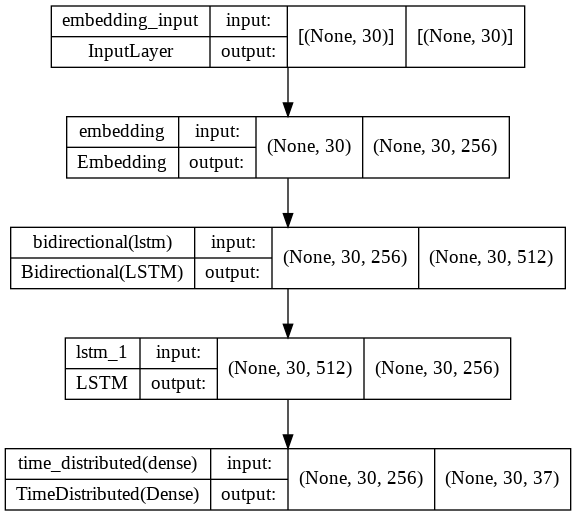

In [ ]:
# plot model architecture
from tensorflow.keras.utils import plot_model
plot_model(model,'model_dimensions.png', show_shapes= True, show_layer_names=True)

### Fit the model

In [ ]:
history= model.fit(train_tokens, np.array(train_tags), batch_size=2, epochs=4, validation_split=0.1)

Epoch 1/4
128/128 [==============================] - 11s 19ms/step - loss: 0.7044 - accuracy: 0.8699 - val_loss: 0.4513 - val_accuracy: 0.8954
Epoch 2/4
128/128 [==============================] - 1s 10ms/step - loss: 0.4351 - accuracy: 0.8867 - val_loss: 0.2917 - val_accuracy: 0.9230
Epoch 3/4
128/128 [==============================] - 1s 10ms/step - loss: 0.2999 - accuracy: 0.9219 - val_loss: 0.2474 - val_accuracy: 0.9310
Epoch 4/4
128/128 [==============================] - 1s 10ms/step - loss: 0.2355 - accuracy: 0.9342 - val_loss: 0.2280 - val_accuracy: 0.9391


### Plot training and validation loss of the model for each epoch

In [ ]:
import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')

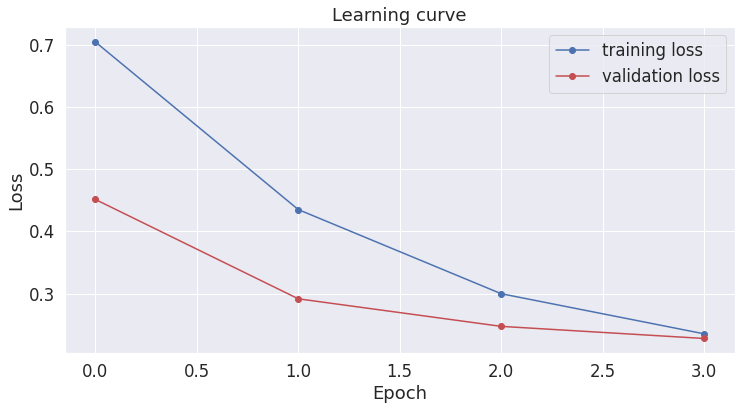

In [ ]:
from matplotlib import pyplot as plt

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(history.history['loss'], 'b-o')
plt.plot(history.history['val_loss'], 'r-o')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

----------------------------------

### Bi-LSTM Evaluation Metrics

In [ ]:
y_pred = model.predict(test_tokens)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(test_tags, -1)

In [ ]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=0b52e3a6aed07acfcc596f00665fefc600333a0200e8cf5d44799b588cdc9793
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
flat_list = [x for xs in y_test_true for x in xs]

In [ ]:
# number of total entinties per tag in the validation/test set
from collections import Counter
c = Counter(flat_list)

print( c.items() )

dict_items([('O', 837), ('B-FLDN', 7), ('I-FLDN', 9), ('B-OBJ', 37), ('B-FLDR', 5), ('I-FLDR', 2), ('I-OBJ', 15), ('B-PROPIR', 5), ('I-PROPIR', 4), ('B-OBJQB', 1), ('I-OBJQB', 1), ('B-CNAC', 4), ('B-EVE', 6), ('B-NETQR', 5), ('I-NETQR', 5), ('B-CVAL', 3), ('I-CVAL', 7), ('I-EVE', 2), ('B-FLDI', 1), ('I-CNAC', 1), ('B-OBJQR', 1), ('B-NET', 1), ('I-NET', 1)])


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 43.5%


In [ ]:
print("Recall is : {:.1%}".format(recall_score(y_test_true, y_pred)))

Recall is : 46.2%


In [ ]:
print("Precision is : {:.1%}".format(precision_score(y_test_true, y_pred)))

Precision is : 41.1%


In [ ]:
report = classification_report(y_pred,y_test_true)
print(report)

              precision    recall  f1-score   support

        CNAC       0.00      0.00      0.00         0
        CVAL       0.67      0.25      0.36         8
         EVE       0.43      0.43      0.43         7
        FLDI       0.00      0.00      0.00         0
        FLDN       0.11      0.09      0.10        11
        FLDR       0.00      0.00      0.00         7
         NET       0.00      0.00      0.00         0
       NETQR       0.00      0.00      0.00         0
         OBJ       0.79      0.64      0.71        47
       OBJQB       0.00      0.00      0.00         0
       OBJQR       0.00      0.00      0.00         0
      PROPIR       0.20      0.10      0.13        10

   micro avg       0.46      0.41      0.44        90
   macro avg       0.18      0.13      0.14        90
weighted avg       0.54      0.41      0.46        90



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test on random question from validation set 

In [ ]:
# words = list(data['word'].unique())
# tags = list(data['tag'].unique())
# num_words = len(words)

In [ ]:
# word2idx = {w: i+1 for i, w in enumerate(words)}
# tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
# i = 2
# p = model.predict(np.array([test_tokens[i]]))
# p = np.argmax(p, axis=-1)
# print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
# for w,pred in zip(test_tokens[i],p[0]):
#     print("{:14}: {}".format(words[w],tags[pred]))

### Bi-LSTM Hyperparameter tunning

In [ ]:
# !pip install -q -U keras-tuner
# import keras_tuner as kt

In [ ]:
# from keras_tuner.tuners import BayesianOptimization
# import os
# from tensorflow import keras
# from tensorflow.keras import layers
# from hyperopt import hp

In [ ]:
# def get_bilstm_lstm_model(hp):
#     model = Sequential()

#     dropout= hp.Choice('dropout', [0.0, 0.1, 0.2, 0.4], default=0.1)
#     rec_dropout = hp.Choice('rec_dropout', [0.0, 0.1, 0.2, 0.4, 0.5], default=0.1)

#     # Add Embedding layer
#     model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     # Add bidirectional LSTM
#     model.add(Bidirectional(LSTM(units=hp_units, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout), merge_mode = 'concat'))

#     # Add LSTM
#     model.add(LSTM(units=hp_units, return_sequences=True, dropout=dropout, recurrent_dropout=rec_dropout))

#     # Add timeDistributed Layer
#     model.add(TimeDistributed(Dense(n_tags, activation=hp.Choice('activation', ['relu','softmax'], default='softmax'))))

#     # Compile model
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#                   loss='categorical_crossentropy', metrics=['accuracy'])
#     model.summary()
    
#     return model

In [ ]:
# tuner = BayesianOptimization(
#     get_bilstm_lstm_model,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=1,
#     directory=os.path.join(os.getcwd(),'drive','MyDrive', 'UTRECHT UNIVERISTY', 'THESIS'),
#     project_name='kerastuner_bayesian_poc_lstm_alltuning_22',
#     overwrite=False)

In [ ]:
# tuner.search_space_summary()

In [ ]:
# import tensorflow as tf
# tuner.search(train_tokens, np.array(train_tags), epochs=20, validation_data=(test_tokens, np.array(test_tags)),
#              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [ ]:
# tuner.results_summary()

In [ ]:
# best_model = tuner.get_best_models()

In [ ]:
# best_hyperparameters = tuner.get_best_hyperparameters()[0]

In [ ]:
# best_hyperparameters.get_config()['values']

In [ ]:
# tuned_model = tuner.hypermodel.build(best_hyperparameters)
# tuned_model.summary()

In [ ]:
# history= tuned_model.fit(train_tokens, np.array(train_tags), batch_size=2, epochs=4, validation_split=0.1)

In [ ]:
# _, acc = tuned_model.evaluate(test_tokens, np.array(test_tags))
# print('Accuracy: %.3f' % (acc *100))

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

###--------------------------------------------------------